# Mô hình nhận diện tin tức giả

In [1]:
import os, csv, sys
import unicodedata as ud

from text_utils import remove_punc, token_sylabling, is_word


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

Update 1: pandas và sklearn có các phương thức hỗ trợ việc load dữ liệu, biểu diễn kết quả

In [61]:
import itertools
import pandas
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

Một số thư viện hỗ trợ đánh giá mô hình và lưu trữ mô hình

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib

Một số đường dẫn lưu và load file

In [21]:
models_path = './Models'

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## 1. Biểu diễn Bag-of-word

In [2]:
preproc_path = './PreprocessingData'

### 1.1. Data 1:  file ```preproc_vn_news_226_tlfr.csv``` - text & label

In [3]:
data1_path = 'preproc_vn_news_226_tlfr.csv'

Load data từ file ```preproc_vn_news_226_tlfr.csv``` là các file đã được tiền xử lý, các record trong file đã được xáo trộn lên theo thứ tự ngẫu nhiên

In [4]:
news_data1 = []

data1_train_text = []
data1_train_label = []

data1_test_text = []
data1_test_label = []

In [5]:
with open(os.path.join(preproc_path, data1_path), 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    news_data1 = list(reader)

Tách dữ liệu thành 2 phần: ```Train``` - 181 record & ```Test``` - 45 record

In [6]:
train_size = 181

news_data1_train = news_data1[:train_size]
news_data1_test = news_data1[train_size:]

Chuẩn bị dữ liệu: Loại bỏ dấu câu, số, ngày tháng, url... -> Chuyển thành chữ viết thường

In [7]:
def data_preparing(text):
    text_list = text.lower().split()
    new_text = ''
    for word in text_list:
        if(is_word(word)):
            new_text = ' '.join([new_text, word])
    return new_text

Chuẩn bị dữ liệu train

In [8]:
for train in news_data1_train:
    data1_train_text.append(data_preparing(train['text']))
    data1_train_label.append(train['label'])

Chuẩn bị dữ liệu test:
```data1_test_label```: chứa các label của dữ liệu test

In [9]:
for test in news_data1_test:
    data1_test_text.append(data_preparing(test['text']))
    data1_test_label.append(test['label'])

Biểu diễn Bag-of-Word cho dữ liệu ```train```

In [29]:
data1_tfidf_vectorizer = TfidfVectorizer()
X_data1_train_tfidf = data1_tfidf_vectorizer.fit_transform(data1_train_text)
print(X_data1_train_tfidf.shape)

(181, 8208)


## 2. Naive Bayes classification

### 2.1. Mô hình cho dữ liệu từ file ```preproc_vn_news_226_tlfr.csv``` - text & label

#### 2.1.1. Mô hình 1
Thực hiện tokenize bằng mô hình của nhóm -> Vectorize bằng TFIDF -> Thực hiện classify bằng Multinomial Naive Bayesian.

In [11]:
MultiNB_clf_1 = MultinomialNB().fit(X_data1_train_tfidf, data1_train_label)


In [20]:
print(MultiNB_clf_1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Ở đây biểu diễn test theo như mô hình TFIDFVectorize vừa tạo ở trên

In [31]:
X_test = data1_tfidf_vectorizer.transform(data1_test_text)

print('Chiều của dữ liệu Test: ',X_test.shape)

Chiều của dữ liệu Test:  (45, 8208)


In [32]:
data1_predict = MultiNB_clf_1.predict(X_test)
data1_predict_log_proba = MultiNB_clf_1.predict_log_proba(X_test)
data1_predict_proba = MultiNB_clf_1.predict_proba(X_test)

Đánh giá Mô hình ```MultiNB_clf_1```:

1. __Accuracy__ của mô hình

In [41]:
np.mean(data1_test_label == data1_predict)

0.9333333333333333

In [63]:
cnf_matrix = confusion_matrix(data1_test_label, data1_predict)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[26  2]
 [ 1 16]]


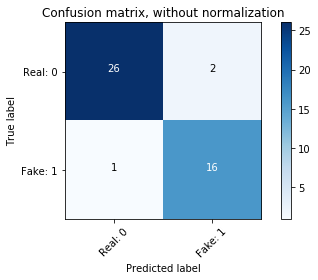

In [67]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix, without normalization')

In [59]:
print(metrics.classification_report(data1_test_label, data1_predict, target_names=['Real', 'Fake']))

             precision    recall  f1-score   support

       Real       0.96      0.93      0.95        28
       Fake       0.89      0.94      0.91        17

avg / total       0.93      0.93      0.93        45



Lưu lại model1: ```MultiNB_clf_1```

In [68]:
model1_files = 'MultiNB_clf_1.sav'
joblib.dump(MultiNB_clf_1, os.path.join(models_path, model1_files))

['./Models/MultiNB_clf_1.sav']

## 3. SVM classification

array([[26,  2],
       [ 1, 16]])

(26, 2, 1, 16)